<h2> (1) Import all relevant libraries, layer and classes <h2>


In [1]:
# General
import os
import time

# Python libraries
import numpy as np, collections
import pydot as pyd
import matplotlib.pyplot as plt
from IPython.display import SVG

# Tensorflow
import tensorflow as tf
from tensorflow import lite

# Keras
import keras.backend as k
from keras import optimizers
from keras import metrics, losses, regularizers
from keras import initializers
from keras.models import load_model, Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten, BatchNormalization, Activation, Reshape
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.utils import plot_model, to_categorical
from keras.utils.vis_utils import model_to_dot

# Scikit-learn
import sklearn.preprocessing as skprep
from sklearn import metrics
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, StratifiedKFold

# Pandas
import pandas as pd

# Seaborn
import seaborn as sn

# CoreML 
import coremltools
import tfcoreml as tf_converter

# Keypoint loader
from auxilary_functions import *
from load_data import * 
from poses_display import *
from printConfusionMatrix import * 
from plotTrainingsHistory import *

time_stamp = time_stamp()

Using TensorFlow backend.
W0718 05:49:41.654291 140691940546368 __init__.py:71] TensorFlow version 1.14.0 detected. Last version known to be fully compatible is 1.13.1 .


<h2> (2) Load and prepare goalkeeper pose data <h2>

In [2]:
DATA_PATH = "./stored_data/"

# load data from json files 
#X, y = load_all_data()
# load data from .npy files 
# (Framrates/Poses-per-sequence: '5' / '10' / '15' / '30' / '45' / '60' / '75' / '90')
X, y = load_stored_data(dir_path=DATA_PATH, num_poses='90')

# split dataset into train and test set
X_train, X_test, y_train_temp, y_test_temp = train_test_split(X, y, test_size = 0.1, random_state = 42)
# Date information
# input training/test data
# X_train = [samples, timesteps, features]
# y_train = [samples, labels]
# output training/test data
# X_test = [samples, timesteps, features]
# y_test = [samples, labels]

# get one hot vector from labels
y_train = to_categorical(y_train_temp, num_classes=6)
y_test = to_categorical(y_test_temp, num_classes=6)

# Some debugging info
print("---------------------------------------")
print("---------------------------------------")
print("Bsic information regardin the data:")
print("---------------------------------------")
print("Trainings data...")
print("... input shape=" + str(X_train.shape))
print("... target shape=" + str(y_train.shape))
print("---------------------------------------")
print("Test data...")
print("... input shape=" + str(X_test.shape))
print("... target shape=" + str(y_test.shape))
print("---------------------------------------")
print("---------------------------------------")

---------------------------------------
---------------------------------------
Bsic information regardin the data:
---------------------------------------
Trainings data...
... input shape=(1196, 90, 26)
... target shape=(1196, 6)
---------------------------------------
Test data...
... input shape=(133, 90, 26)
... target shape=(133, 6)
---------------------------------------
---------------------------------------


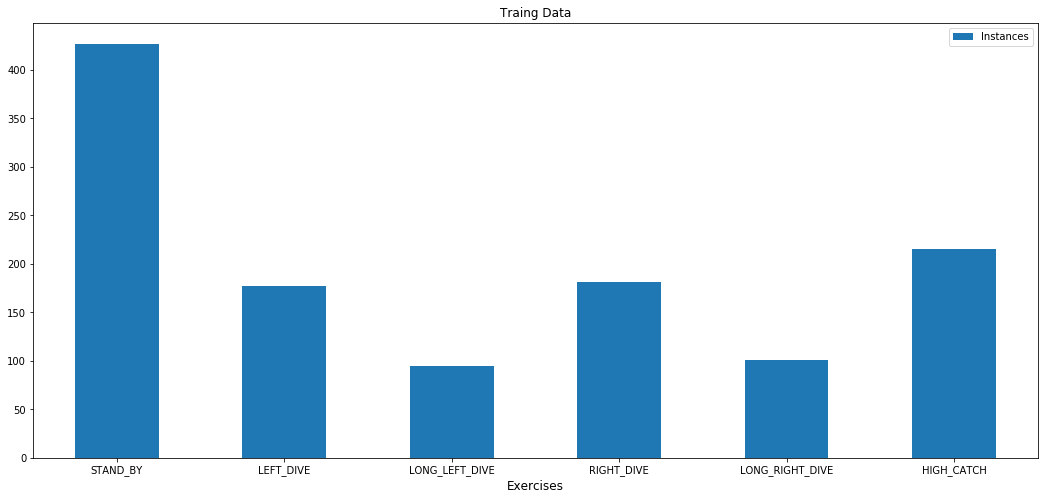

In [3]:
unique, counts = np.unique(y_train_temp, return_counts=True)

tempLABELS = np.asarray([    
    "STAND_BY",
    "LEFT_DIVE",
    "LONG_LEFT_DIVE",
    "RIGHT_DIVE",
    "LONG_RIGHT_DIVE",
    "HIGH_CATCH",
])

df = pd.DataFrame({'Instances':counts}, index=tempLABELS)
ax = df.plot.bar(title ="Traing Data", figsize=(18,8), rot=0)
ax.set_xlabel("Exercises", fontsize=12)
plt.show()

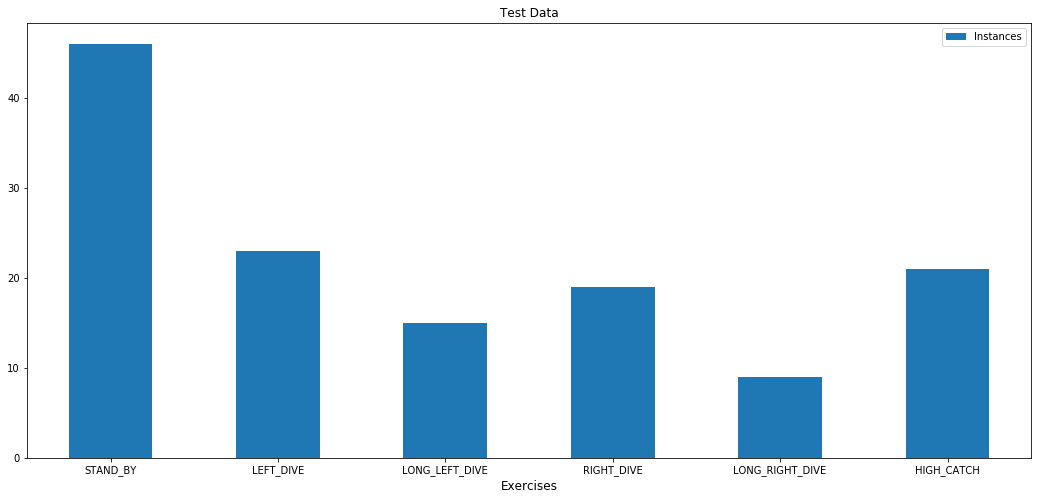

In [4]:
unique_test, counts_test = np.unique(y_test_temp, return_counts=True)

df = pd.DataFrame({'Instances':counts_test}, index=tempLABELS)
ax = df.plot.bar(title ="Test Data", figsize=(18,8), rot=0)
ax.set_xlabel("Exercises", fontsize=12)
plt.show()

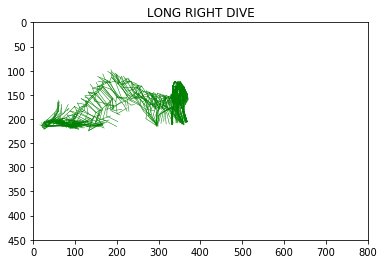

In [5]:
plot_trainings_data(X_train, y_train_temp, sample=100)

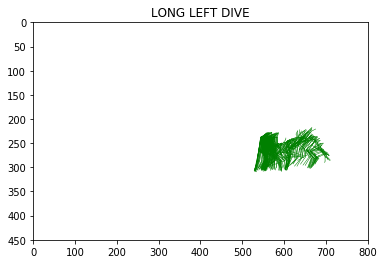

In [6]:
plot_trainings_data(X_train, y_train_temp, sample=666)

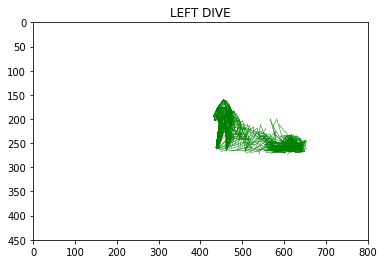

In [7]:
plot_trainings_data(X_train, y_train_temp, sample=1030)

<h2> (3) Define constants and additional parameters <h2>

In [8]:
# Input features
INPUT = [
    "HEAD_X",
    "HEAD_Y_",
    "BODY_X",
    "BODY_Y",
    "LEFT_ARM_X",
    "LEFT_ARM_Y",
    "RIGHT_ARM_X",
    "RIGHT_ARM_Y",
    "LEFT_LEG_X",
    "LEFT_LEG_Y",
    "RIGHT_LEG_X",
    "RIGHT_LEG_Y",
]

# Output classes
LABELS = [    
    "STAND_BY",
    #"SHORT_LEFT_DIVE",
    "LEFT_DIVE",
    "LONG_LEFT_DIVE",
    #"SHORT_RIGHT_DIVE",
    "RIGHT_DIVE",
    "LONG_RIGHT_DIVE",
    #"LOW_CATCH",
    #"MIDDLE_CATCH",
    "HIGH_CATCH",
]

# Input Data
n_timesteps = X_train.shape[1] #len(X_train[1])  # n-timesteps per series per series
n_features = X_train.shape[2] #len(X_train[0][0])  # n input parameters per timestep

# LSTM Neural Network's internal structure
input_shape = (n_timesteps, n_features)
n_mem_units = 192 # Hidden layer num of features
n_classes = len(LABELS) # n classes (should go up, or should go down)

# Training - Hyperparameter  
learning_rate = 0.008 
optimizer = optimizers.Adam(lr=learning_rate, decay=1) 
n_epochs = 100  
batch_size = 540

<h2> (4) Define and build sequence model <h2>

In [9]:
# Weight classes to overcome the unbalanced data
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train_temp), y_train_temp)
sample_weights = class_weight.compute_sample_weight('balanced', y_train_temp)


# Start sequentially defining model 
model = Sequential(name = 'Activity Engine')

# Reshape input
model.add(Reshape(input_shape, input_shape=(n_timesteps * n_features,)))

## Temporal feature extraction - multiple LSTM layer
model.add(LSTM(n_mem_units,
               name = 'LSTM_Layer1',
               return_sequences=True,
               kernel_initializer='random_uniform',
               input_shape=input_shape))
model.add(LSTM(n_mem_units,
               name = 'LSTM_Layer2',
               return_sequences=True,
               kernel_initializer='random_uniform'))
model.add(LSTM(n_mem_units,
               name = 'LSTM_Layer3',
               return_sequences=False,
               kernel_initializer='random_uniform'))

## Classification - fully-connected network
model.add(Dense(96, 
                #activation='relu',
                name = 'Feature_Layer1',
                kernel_initializer='random_uniform',
                bias_initializer='zeros'))

model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(96, 
                #activation='relu',
                name = 'Feature_Layer2',
                kernel_initializer='random_uniform',
                bias_initializer='zeros'))

model.add(BatchNormalization())
model.add(Activation('relu'))

## Output layer
model.add(Dense(n_classes, activation='softmax', name = 'Output_Layer'))

#weighted_categorical_crossentropy(weights)
# Build model 
model.compile(loss=losses.categorical_crossentropy, 
              optimizer=optimizer,
              metrics=['mse', 'accuracy'])

# Print model details/summary
model.summary()

# Model abstract information
model.author = 'Goalplay'
model.short_description = 'Activity Recognition with goalplayer training'

# Visualize model
plot_model(model, to_file='../trainings_history/model_visualize/model_' + time_stamp + '.png', show_shapes=True, show_layer_names=True)

W0718 05:49:49.301110 140691940546368 deprecation_wrapper.py:119] From /home/sami/anaconda3/envs/tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0718 05:49:49.302116 140691940546368 deprecation_wrapper.py:119] From /home/sami/anaconda3/envs/tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0718 05:49:49.314528 140691940546368 deprecation_wrapper.py:119] From /home/sami/anaconda3/envs/tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0718 05:49:50.225491 140691940546368 deprecation_wrapper.py:119] From /home/sami/anaconda3/envs/tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please us

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 90, 26)            0         
_________________________________________________________________
LSTM_Layer1 (LSTM)           (None, 90, 192)           168192    
_________________________________________________________________
LSTM_Layer2 (LSTM)           (None, 90, 192)           295680    
_________________________________________________________________
LSTM_Layer3 (LSTM)           (None, 192)               295680    
_________________________________________________________________
Feature_Layer1 (Dense)       (None, 96)                18528     
_________________________________________________________________
batch_normalization_1 (Batch (None, 96)                384       
_________________________________________________________________
activation_1 (Activation)    (None, 96)                0         
__________

<h2> (5) Record and store process of models/training <h2>

In [10]:
# Tensorboard
logdir = './training_history/logs/' + time_stamp

## Check whether the target directoy exist and 
if not os.path.exists(logdir):
    os.makedirs(logdir)
    
## Create callback for tensorboard/trainings-history with the path to the logs directory
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Model saving
## Create directory which will contain trained models 
model_directory = "./training_history/saved_models/" + time_stamp

## Check whether the target directoy exist and 
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

## Create callback which stores model-weights checkpoints
checkpointer = ModelCheckpoint(filepath=model_directory + '/weights.{epoch:03d}-{val_loss:.2f}.hdf5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)
#earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, baseline=0.8, restore_best_weights=True)
csv_logger = CSVLogger(model_directory + '/training.log')

# Generate callback list 
callbacks = [tensorboard, checkpointer, reduce_lr]

<h2> (6) Train model <h2>

In [11]:
# Reshape model fo CoreML model 
reshaped_X_train = X_train.reshape(X_train.shape[0],-1)

# Train model on trainings data 
history = model.fit(reshaped_X_train, 
                    y_train, 
                    verbose=1, 
                    shuffle=True, 
                    epochs=n_epochs, 
                    validation_split=0.2, 
                    batch_size=batch_size, 
                    callbacks=callbacks,
                    sample_weight=sample_weights,
                    class_weight=class_weights)

print(model.metrics_names)
print(model.evaluate(reshaped_X_train, y_train))

/home/sami/anaconda3/envs/tf/lib/python3.6/site-packages/keras/engine/training_utils.py:481: UserWarning: Found both `sample_weight` and `class_weight`: `class_weight` argument will be ignored.
  warnings.warn('Found both `sample_weight` and `class_weight`: '
W0718 05:49:50.775156 140691940546368 deprecation.py:323] From /home/sami/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 956 samples, validate on 240 samples
Epoch 1/100
956/956 [==============================] - 14s 15ms/step - loss: 1.9393 - mean_squared_error: 0.1389 - acc: 0.2709 - val_loss: 5.8581 - val_mean_squared_error: 0.2256 - val_acc: 0.2167
Epoch 2/100
956/956 [==============================] - 8s 8ms/step - loss: 1.6018 - mean_squared_error: 0.1435 - acc: 0.2636 - val_loss: 3.0513 - val_mean_squared_error: 0.1918 - val_acc: 0.1875
Epoch 3/100
956/956 [==============================] - 9s 9ms/step - loss: 1.4112 - mean_squared_error: 0.1284 - acc: 0.2981 - val_loss: 2.3506 - val_mean_squared_error: 0.2012 - val_acc: 0.1958
Epoch 4/100
956/956 [==============================] - 9s 10ms/step - loss: 1.2479 - mean_squared_error: 0.1175 - acc: 0.3588 - val_loss: 1.7888 - val_mean_squared_error: 0.1562 - val_acc: 0.2250
Epoch 5/100
956/956 [==============================] - 9s 10ms/step - loss: 1.1210 - mean_squared_error: 0.1071 - acc: 0.4456 - val_loss: 1.6028 - val_mean_squared_error: 

956/956 [==============================] - 9s 9ms/step - loss: 0.4889 - mean_squared_error: 0.0518 - acc: 0.7709 - val_loss: 0.9679 - val_mean_squared_error: 0.0867 - val_acc: 0.5792
Epoch 43/100
956/956 [==============================] - 9s 9ms/step - loss: 0.4785 - mean_squared_error: 0.0500 - acc: 0.7866 - val_loss: 0.9751 - val_mean_squared_error: 0.0872 - val_acc: 0.6000
Epoch 44/100
956/956 [==============================] - 9s 9ms/step - loss: 0.4781 - mean_squared_error: 0.0504 - acc: 0.7887 - val_loss: 1.0074 - val_mean_squared_error: 0.0935 - val_acc: 0.5500
Epoch 45/100
956/956 [==============================] - 9s 9ms/step - loss: 0.4659 - mean_squared_error: 0.0491 - acc: 0.7918 - val_loss: 0.9533 - val_mean_squared_error: 0.0847 - val_acc: 0.6083
Epoch 46/100
956/956 [==============================] - 9s 9ms/step - loss: 0.4593 - mean_squared_error: 0.0487 - acc: 0.8002 - val_loss: 0.9005 - val_mean_squared_error: 0.0819 - val_acc: 0.6458
Epoch 47/100
956/956 [===========

Epoch 84/100
956/956 [==============================] - 9s 10ms/step - loss: 0.3873 - mean_squared_error: 0.0407 - acc: 0.8431 - val_loss: 0.7778 - val_mean_squared_error: 0.0671 - val_acc: 0.7375
Epoch 85/100
956/956 [==============================] - 9s 10ms/step - loss: 0.3865 - mean_squared_error: 0.0405 - acc: 0.8431 - val_loss: 0.7757 - val_mean_squared_error: 0.0667 - val_acc: 0.7333
Epoch 86/100
956/956 [==============================] - 9s 9ms/step - loss: 0.3848 - mean_squared_error: 0.0404 - acc: 0.8379 - val_loss: 0.7775 - val_mean_squared_error: 0.0668 - val_acc: 0.7250
Epoch 87/100
956/956 [==============================] - 9s 9ms/step - loss: 0.3866 - mean_squared_error: 0.0405 - acc: 0.8421 - val_loss: 0.7800 - val_mean_squared_error: 0.0670 - val_acc: 0.7375
Epoch 88/100
956/956 [==============================] - 9s 9ms/step - loss: 0.3846 - mean_squared_error: 0.0403 - acc: 0.8410 - val_loss: 0.7800 - val_mean_squared_error: 0.0672 - val_acc: 0.7208
Epoch 89/100
956/9

<h2> (7) Predict and evaluate <h2>

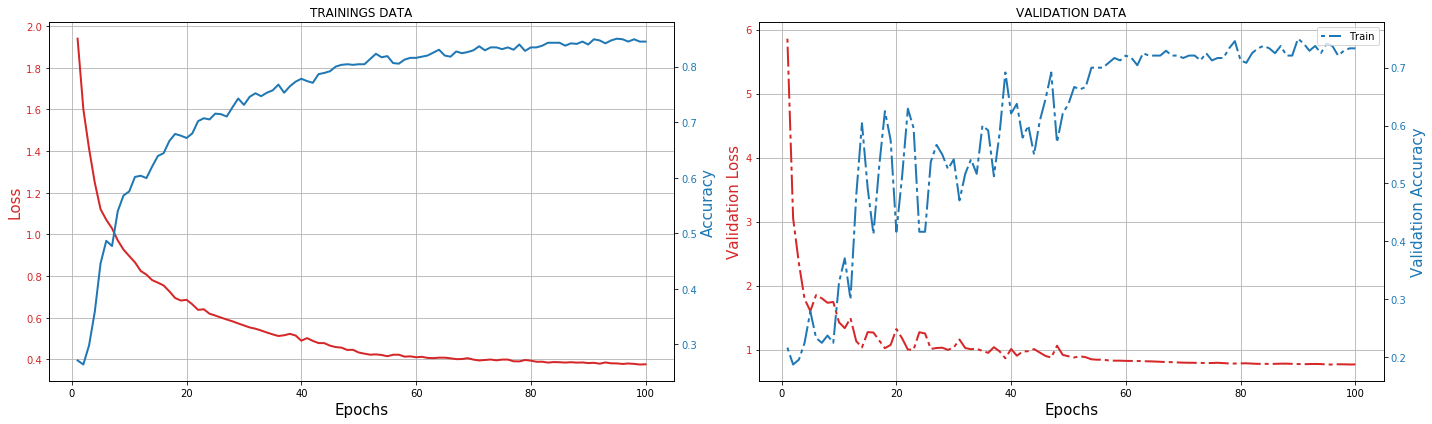

Train accuracy: [0.5245555280443019, 0.04607954399541868, 0.8219063543157036]
Test accuracy: [0.577593571709511, 0.054450115651116335, 0.7669172932330827]


In [12]:
# Plot history 
plot_loss_acc(model)

# Reshape X_test data
reshaped_X_test = X_test.reshape(X_test.shape[0],-1)

# evaluate the model
train_acc = model.evaluate(reshaped_X_train, y_train, verbose=0)
test_acc = model.evaluate(reshaped_X_test, y_test, verbose=0)
print('Train accuracy: ' + str(train_acc))
print('Test accuracy: ' + str(test_acc))

In [13]:
y_predicted_classes = model.predict_classes(reshaped_X_test)
y_prediction_prob = model.predict(reshaped_X_test)

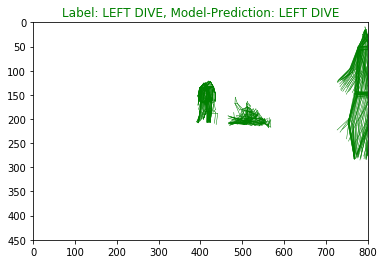

In [14]:
plot_test_data(X_test, y_predicted_classes, y_test_temp, sample=69)

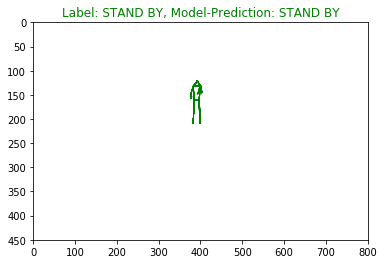

In [15]:
plot_test_data(X_test, y_predicted_classes, y_test_temp, sample=14)

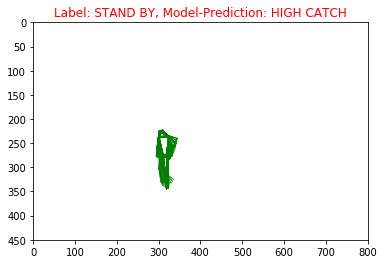

In [16]:
plot_test_data(X_test, y_predicted_classes, y_test_temp, sample=9)

<h2> (8) Save model <h2>

In [17]:
# Save trained model
saved_model = model_directory + "/activity_recognition_model.h5"
model.save(saved_model)

In [18]:
# Convert trained model into CoreML
coreml_model = coremltools.converters.keras.convert(saved_model, 
                                                    class_labels=LABELS, 
                                                    input_names=['pose'])

# Store CoreML model 
coreml_model.save(model_directory + "/activity_recognition_model.mlmodel")

0 : reshape_1_input, <keras.engine.input_layer.InputLayer object at 0x7ff500551b00>
1 : reshape_1, <keras.layers.core.Reshape object at 0x7ff500551a90>
2 : LSTM_Layer1, <keras.layers.recurrent.LSTM object at 0x7ff500551b38>
3 : LSTM_Layer2, <keras.layers.recurrent.LSTM object at 0x7ff500551c18>
4 : LSTM_Layer3, <keras.layers.recurrent.LSTM object at 0x7ff434551208>
5 : Feature_Layer1, <keras.layers.core.Dense object at 0x7ff5005523c8>
6 : batch_normalization_1, <keras.layers.normalization.BatchNormalization object at 0x7ff4d0285b38>
7 : activation_1, <keras.layers.core.Activation object at 0x7ff43c2e7b70>
8 : Feature_Layer2, <keras.layers.core.Dense object at 0x7ff3e47b14e0>
9 : batch_normalization_2, <keras.layers.normalization.BatchNormalization object at 0x7ff3e4789ba8>
10 : activation_2, <keras.layers.core.Activation object at 0x7ff3e474ecf8>
11 : Output_Layer, <keras.layers.core.Dense object at 0x7ff3e4711400>
12 : Output_Layer__activation__, <keras.layers.core.Activation object a

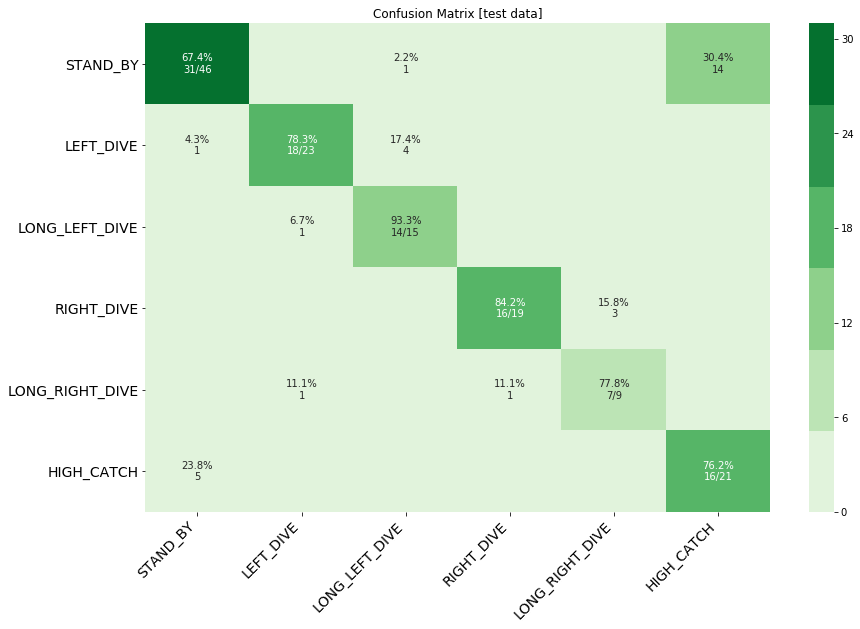

In [19]:
# Generate confusion matrix test data 
matrix = metrics.confusion_matrix(y_test_temp, y_predicted_classes, labels=np.unique(y_test_temp))
print_confusion_matrix(matrix, LABELS, figsize = (14,9), cmap=sn.color_palette("Greens"))

In [20]:
# Generate confusion matrix test data 
#y_predicted_classes = model.predict_classes(reshaped_X_test)
#matrix = metrics.confusion_matrix(y_test_temp, y_predicted_classes, labels=np.unique(y_test_temp))
#print_confusion_matrix(matrix, LABELS, dataset=='train', figsize = (14,9), cmap=sn.color_palette("Greens"))

NameError: name 'dataset' is not defined